In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA = Path("../datasets")

paysim = pd.read_parquet(DATA / "paysim_sample.parquet")
ccf    = pd.read_parquet(DATA / "credit_card_fraud.parquet")
pep    = pd.read_parquet(DATA / "opensanctions_pep_sample.parquet")

paysim.head(), ccf.head(), pep.head()


(                   ts  cpf device_id            ip      asn       city  \
 0 2025-09-01 10:00:00  111      devA  200.100.10.1    AS123   Campinas   
 1 2025-09-01 10:02:00  111      devA  200.100.10.1    AS123   Campinas   
 2 2025-09-01 11:10:00  333      devD       8.8.8.8  AS15169  São Paulo   
 3 2025-09-01 10:03:00  111      devB   177.23.44.9    AS456  São Paulo   
 4 2025-09-01 10:25:00  111      devC      18.5.6.7    AS789        Rio   
 
    amount currency channel merchant_id beneficiary_id     type  
 0     120      BRL     app         m01            b01  payment  
 1     180      BRL     app         m02            b02  payment  
 2      10      BRL     app         m01            b06  deposit  
 3     300      BRL     web         m03            b03  payment  
 4     700      BRL     web         m04            b05  payment  ,
                    ts card_id  cpf  amount       city channel  is_fraud
 0 2025-09-01 08:00:00    c001  111     120   Campinas     app         0
 1 20

In [2]:
def quick_info(df, name):
    print(f"== {name} ==")
    print("shape:", df.shape)
    print("dtypes:\n", df.dtypes, "\n")
    print("nulls:\n", df.isna().sum(), "\n")

quick_info(paysim, "PaySim")
quick_info(ccf, "Credit Card Fraud")
quick_info(pep, "OpenSanctions (PEP sample)")


== PaySim ==
shape: (6, 12)
dtypes:
 ts                datetime64[ns]
cpf                        int64
device_id                 object
ip                        object
asn                       object
city                      object
amount                     int64
currency                  object
channel                   object
merchant_id               object
beneficiary_id            object
type                      object
dtype: object 

nulls:
 ts                0
cpf               0
device_id         0
ip                0
asn               0
city              0
amount            0
currency          0
channel           0
merchant_id       0
beneficiary_id    0
type              0
dtype: int64 

== Credit Card Fraud ==
shape: (5, 7)
dtypes:
 ts          datetime64[ns]
card_id             object
cpf                  int64
amount               int64
city                object
channel             object
is_fraud             int64
dtype: object 

nulls:
 ts          0
card_id     0


In [3]:
# datetime + sort
for df in [paysim, ccf]:
    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df.sort_values("ts", inplace=True)

# padroniza textos (evita espaços)
for col in ["cpf", "device_id", "ip", "city", "channel", "beneficiary_id", "merchant_id"]:
    if col in paysim.columns:
        paysim[col] = paysim[col].astype(str).str.strip()

if "cpf" in ccf.columns:
    ccf["cpf"] = ccf["cpf"].astype(str).str.strip()

paysim.head(3)


,ts,cpf,device_id,ip,asn,city,amount,currency,channel,merchant_id,beneficiary_id,type
0,2025-09-01 10:00:00,111,devA,200.100.10.1,AS123,Campinas,120,BRL,app,m01,b01,payment
1,2025-09-01 10:02:00,111,devA,200.100.10.1,AS123,Campinas,180,BRL,app,m02,b02,payment
3,2025-09-01 10:03:00,111,devB,177.23.44.9,AS456,São Paulo,300,BRL,web,m03,b03,payment


Matplotlib is building the font cache; this may take a moment.


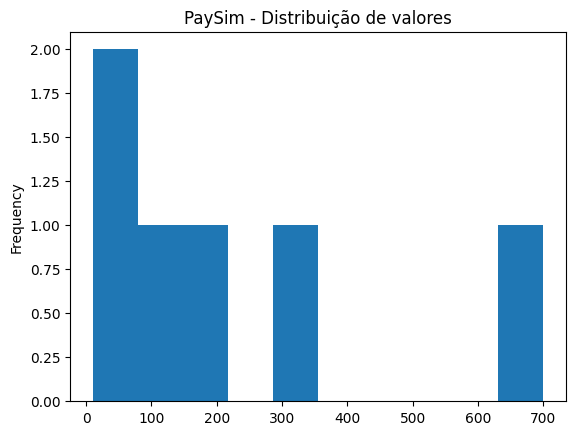

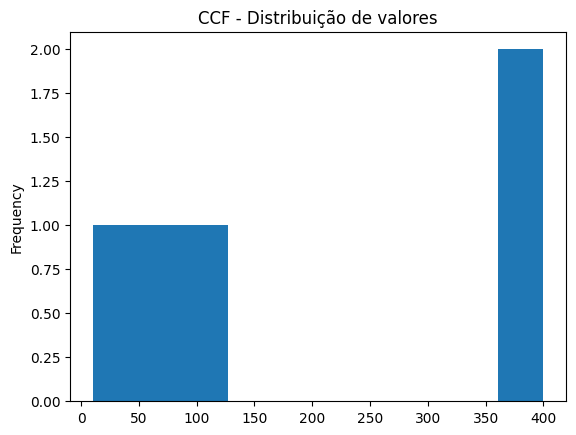

In [4]:
import matplotlib.pyplot as plt

if "amount" in paysim.columns:
    paysim["amount"].plot(kind="hist", bins=10, title="PaySim - Distribuição de valores")
    plt.show()

if "amount" in ccf.columns:
    ccf["amount"].plot(kind="hist", bins=10, title="CCF - Distribuição de valores")
    plt.show()


In [7]:
# Garantias (não faz mal repetir)
assert "ts" in paysim.columns and "cpf" in paysim.columns and "amount" in paysim.columns, "Cols faltando"
paysim["ts"] = pd.to_datetime(paysim["ts"], errors="coerce")
paysim = paysim.sort_values(["cpf","ts"]).reset_index(drop=True)


In [8]:
# Cálculo da contagem de transações em janela móvel de 10 minutos por CPF,
# sem precisar fazer merge depois.
tx_count = (
    paysim
    .groupby("cpf")
    .rolling("10min", on="ts")["amount"]
    .count()
    .reset_index(level=0, drop=True)
)

paysim["tx_count_10min"] = tx_count
paysim[["ts","cpf","amount","tx_count_10min"]].head(10)


,ts,cpf,amount,tx_count_10min
0,2025-09-01 10:00:00,111,120,NaN
1,2025-09-01 10:02:00,111,180,NaN
2,2025-09-01 10:03:00,111,300,NaN
3,2025-09-01 10:25:00,111,700,NaN
4,2025-09-01 10:20:00,222,50,NaN
5,2025-09-01 11:10:00,333,10,NaN


In [1]:
# mapa simples de beneficiário -> nome (mock de cadastro)
bene_map = {"b01":"João Silva","b02":"Loja XPTO","b03":"Maria Souza","b04":"Empresa ABC","b05":"Serviço Z","b06":"Fulano Teste"}

if "beneficiary_id" in paysim.columns:
    paysim["beneficiary_name"] = paysim["beneficiary_id"].map(bene_map).fillna("UNKNOWN")
    alertas_pep = paysim.merge(pep, left_on="beneficiary_name", right_on="name", how="left", indicator=True)

    # pequena amostra dos matches (se houver)
    display(alertas_pep.loc[alertas_pep["_merge"]=="both", 
                            ["ts","cpf","beneficiary_id","beneficiary_name","source_list"]].head(10))


NameError: name 'paysim' is not defined

In [2]:
# IMPORTS e caminhos
import pandas as pd
import numpy as np
from pathlib import Path

# Confere diretório atual do notebook (deve ser .../blue-team-aml-portfolio/pandas)
import os
print("CWD:", os.getcwd())

DATA = Path("../datasets")
assert DATA.exists(), f"Pasta {DATA} não encontrada. Verifique caminho."

# Carregar datasets (Parquet gerados no Dia 2)
paysim = pd.read_parquet(DATA / "paysim_sample.parquet")
ccf    = pd.read_parquet(DATA / "credit_card_fraud.parquet")
pep    = pd.read_parquet(DATA / "opensanctions_pep_sample.parquet")

print("OK: datasets carregados")
paysim.head(2), ccf.head(2), pep.head(2)


CWD: /Users/ricardoalmeida/Projetos/blue-team-aml-portfolio/pandas
OK: datasets carregados


(                   ts  cpf device_id            ip    asn      city  amount  \
 0 2025-09-01 10:00:00  111      devA  200.100.10.1  AS123  Campinas     120   
 1 2025-09-01 10:02:00  111      devA  200.100.10.1  AS123  Campinas     180   
 
   currency channel merchant_id beneficiary_id     type  
 0      BRL     app         m01            b01  payment  
 1      BRL     app         m02            b02  payment  ,
                    ts card_id  cpf  amount       city channel  is_fraud
 0 2025-09-01 08:00:00    c001  111     120   Campinas     app         0
 1 2025-09-01 08:07:00    c001  111     400  São Paulo     web         1,
           name    doc_id country    source_list
 0   João Silva  pep-0001      BR  PEP_BR_SAMPLE
 1  Maria Souza  pep-0002      BR  PEP_BR_SAMPLE)

In [3]:
# mapa simples de beneficiário -> nome (mock de cadastro)
bene_map = {
    "b01":"João Silva","b02":"Loja XPTO","b03":"Maria Souza",
    "b04":"Empresa ABC","b05":"Serviço Z","b06":"Fulano Teste"
}

assert "beneficiary_id" in paysim.columns, "Coluna 'beneficiary_id' não existe em paysim"

paysim["beneficiary_name"] = paysim["beneficiary_id"].map(bene_map).fillna("UNKNOWN")

# Match por nome com PEP (atenção: em produção, normalizar nomes, acentos, etc.)
alertas_pep = paysim.merge(
    pep, left_on="beneficiary_name", right_on="name",
    how="left", indicator=True
)

print("Linhas com match PEP:", (alertas_pep["_merge"]=="both").sum())
display(
    alertas_pep.loc[alertas_pep["_merge"]=="both",
                    ["ts","cpf","beneficiary_id","beneficiary_name","source_list"]].head(10)
)


Linhas com match PEP: 2


,ts,cpf,beneficiary_id,beneficiary_name,source_list
0,2025-09-01 10:00:00,111,b01,João Silva,PEP_BR_SAMPLE
3,2025-09-01 10:03:00,111,b03,Maria Souza,PEP_BR_SAMPLE


In [4]:
from pathlib import Path
Path("../reports/eda").mkdir(parents=True, exist_ok=True)

# salva as linhas com match (se houver)
(alertas_pep.loc[alertas_pep["_merge"]=="both",
                 ["ts","cpf","beneficiary_id","beneficiary_name","source_list"]]
 .to_csv("../reports/eda/pep_matches_sample.csv", index=False))

print("OK: evidências salvas em reports/eda/pep_matches_sample.csv")


OK: evidências salvas em reports/eda/pep_matches_sample.csv
